In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from yahoo_fin.stock_info import get_data  

In [24]:
df=pd.read_csv('reliance.csv',parse_dates=True,index_col='Unnamed: 0')

In [25]:
df2=df[['close']].copy()

In [26]:
df2

,close
2000-01-03,35.945827
2000-01-04,38.823490
2000-01-05,40.344440
2000-01-06,42.036766
2000-01-07,44.921570
...,...
2024-04-24,2900.350098
2024-04-25,2919.949951
2024-04-26,2905.100098
2024-04-29,2930.050049


In [27]:
df2=df2.asfreq('b')

In [28]:
df2=df2.interpolate(method='linear')

In [29]:
df3=df2[['close']].copy()

<Axes: >

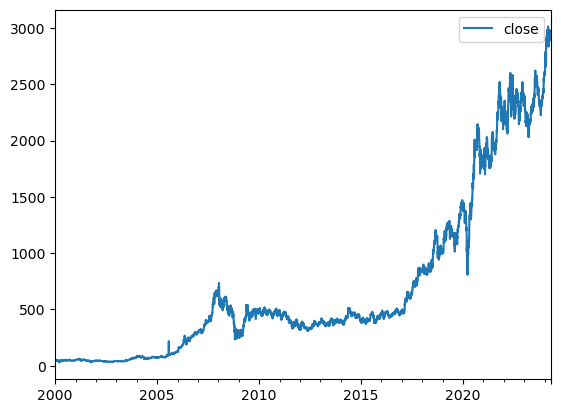

In [30]:
df2.plot()

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
minmax=MinMaxScaler(feature_range=(0,1))

In [33]:
df2=minmax.fit_transform(np.array(df2))

In [34]:
df2.shape

(6347, 1)

In [35]:
df2

array([[0.00231979],
       [0.00328358],
       [0.00379298],
       ...,
       [0.96325921],
       [0.97161546],
       [0.97293838]])

In [36]:
test_data=df2[6084:]
train_data=df2[:6084]

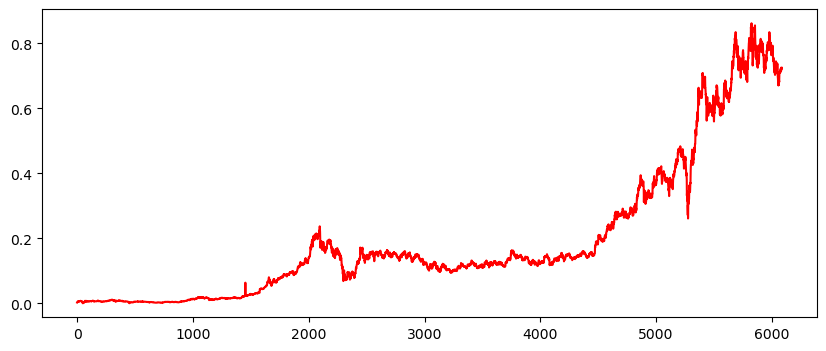

In [37]:
plt.figure(figsize=(10,4))
plt.plot(train_data,color='red')

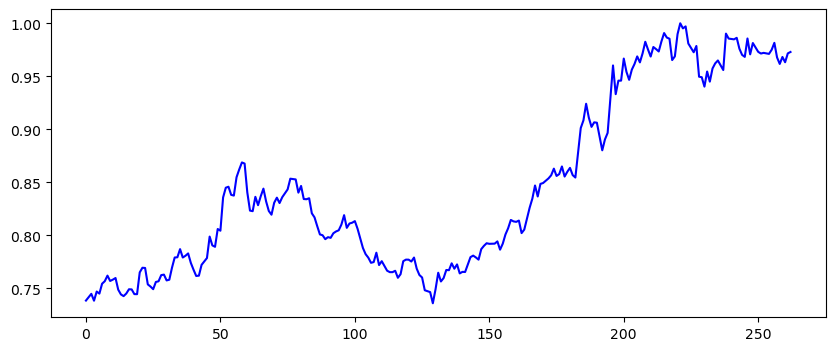

In [38]:
plt.figure(figsize=(10,4))
plt.plot(test_data,color='blue')

In [39]:
def prepare_data(data, n_features):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    x = np.array(x)
    y = np.array(y)
    
    # Flatten each sequence in x to create a 2D array
    x = x.reshape((x.shape[0], -1))
    
    return x, y

In [55]:
x_train,y_train=prepare_data(train_data,70)

In [56]:
x_test,y_test=prepare_data(test_data,70)

In [57]:
x_train.shape

(6014, 70)

In [20]:
model=Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [22]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

95/95 [==============================] - 9s 56ms/step - loss: 0.0123 - val_loss: 0.0039
Epoch 2/100
95/95 [==============================] - 5s 52ms/step - loss: 3.1435e-04 - val_loss: 0.0039
Epoch 3/100
95/95 [==============================] - 5s 47ms/step - loss: 3.0023e-04 - val_loss: 5.7916e-04
Epoch 4/100
95/95 [==============================] - 5s 54ms/step - loss: 2.5787e-04 - val_loss: 0.0015
Epoch 5/100
95/95 [==============================] - 5s 53ms/step - loss: 2.8554e-04 - val_loss: 0.0015
Epoch 6/100
95/95 [==============================] - 5s 49ms/step - loss: 2.7467e-04 - val_loss: 0.0014
Epoch 7/100
95/95 [==============================] - 5s 49ms/step - loss: 2.1396e-04 - val_loss: 0.0014
Epoch 8/100
95/95 [==============================] - 5s 51ms/step - loss: 2.1351e-04 - val_loss: 0.0018
Epoch 9/100
95/95 [==============================] - 5s 51ms/step - loss: 2.0053e-04 - val_loss: 0.0012
Epoch 10/100
95/95 [==============================] - 5s 48ms/s

7/7 [==============================] - 0s 18ms/step


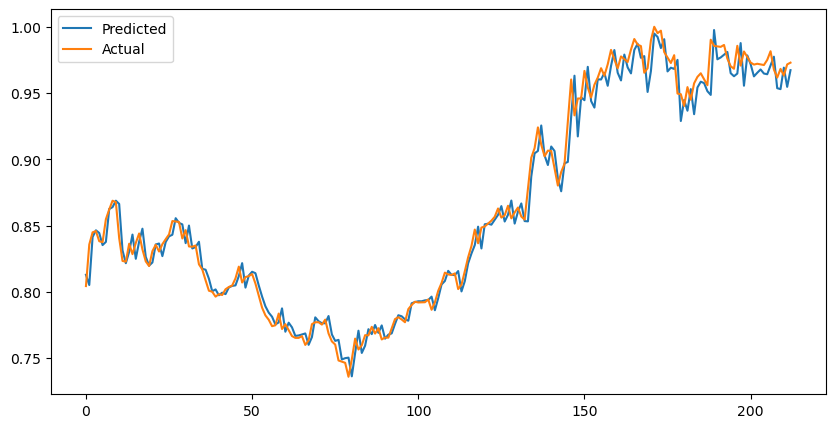

In [24]:
predt_lstm=model.predict(x_test)
plt.figure(figsize=(10,5))
mse_lstm=mean_squared_error(y_test,predt_lstm)
mape_lstm=mean_absolute_percentage_error(y_test,predt_lstm)
plt.plot(predt_lstm,label='Predicted')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()

### Linear Regression

In [58]:
liner_model=LinearRegression().fit(x_train,y_train)
predt_linear2=liner_model.predict(x_test)
mse_linear=mean_squared_error(y_test,predt_linear2)
mape_linear=mean_absolute_percentage_error(y_test,predt_linear2)

In [59]:
mse_linear

8.97422972149911e-05

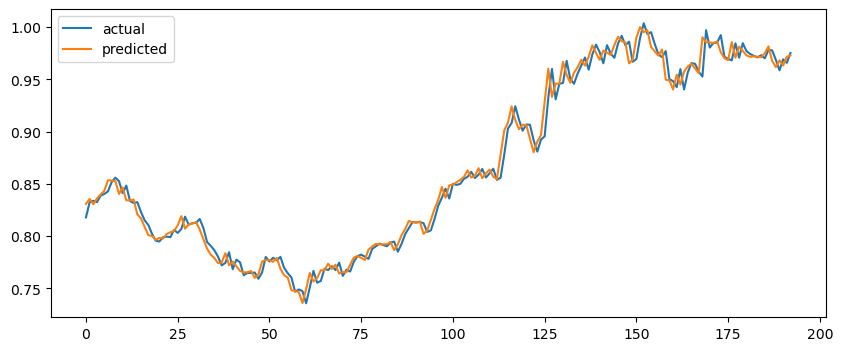

In [22]:
plt.figure(figsize=(10,4))
plt.plot(predt_linear2,label='actual')
plt.plot(y_test,label='predicted')
plt.legend()
plt.show()

In [28]:
def tuning(model,params):
    '''model,params,features'''
    grid=GridSearchCV(model,params,n_jobs=-1)
    grid.fit(x_train,y_train)
    bestp=grid.best_params_
    bestsc=grid.best_score_
    return bestp,bestsc

### Decision Tree

In [29]:
param_grid = {
    'criterion': ['mse', 'friedman_mse'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

In [30]:
#tuning(DecisionTreeRegressor(),param_grid)

In [31]:
model_dec=DecisionTreeRegressor(splitter='best',min_samples_leaf=5,min_samples_split=10,min_impurity_decrease=0.0,max_leaf_nodes=None,max_features=None,max_depth=10,criterion='friedman_mse',ccp_alpha=0.0).fit(x_train,y_train)

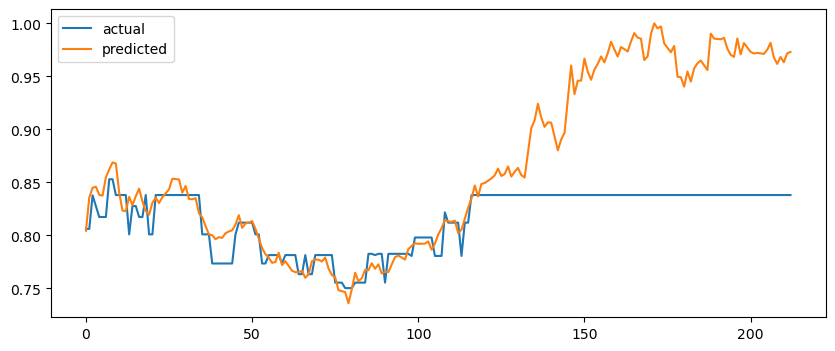

In [32]:
predt_dec=model_dec.predict(x_test)
mse_dec=mean_squared_error(y_test,predt_dec)
mape_dec=mean_absolute_percentage_error(y_test,predt_dec)
plt.figure(figsize=(10,4))
plt.plot(predt_dec,label='actual')
plt.plot(y_test,label='predicted')
plt.legend()
plt.show()

### Random Forest

In [33]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
#tuning(RandomForestRegressor(),param_grid)

In [36]:
model_random=RandomForestRegressor(bootstrap=True,max_depth=20,max_features='sqrt',min_samples_split=2,min_samples_leaf=2,n_estimators=100)

C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


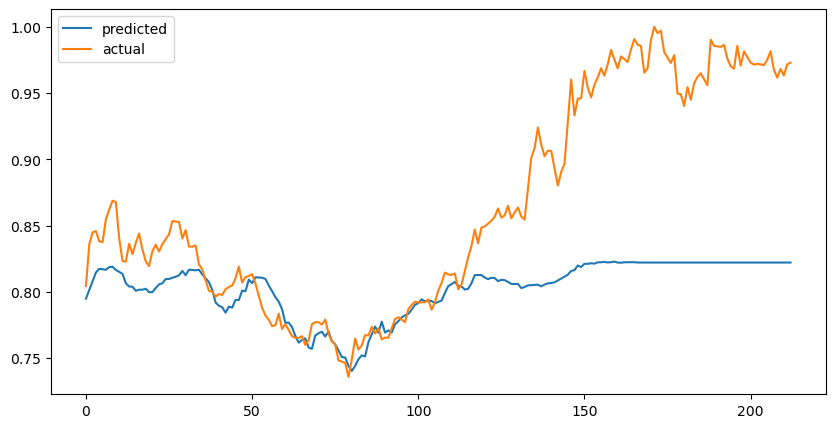

In [37]:
model_random.fit(x_train,y_train)
predt_random=model_random.predict(x_test)
mse_random=mean_squared_error(y_test,predt_random)
mape_random=mean_absolute_percentage_error(y_test,predt_random)
plt.figure(figsize=(10,5))
plt.plot(predt_random,label='predicted')
plt.plot(y_test,label='actual')
plt.legend()
plt.show()

### XGBoost

In [38]:
from xgboost import XGBRegressor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


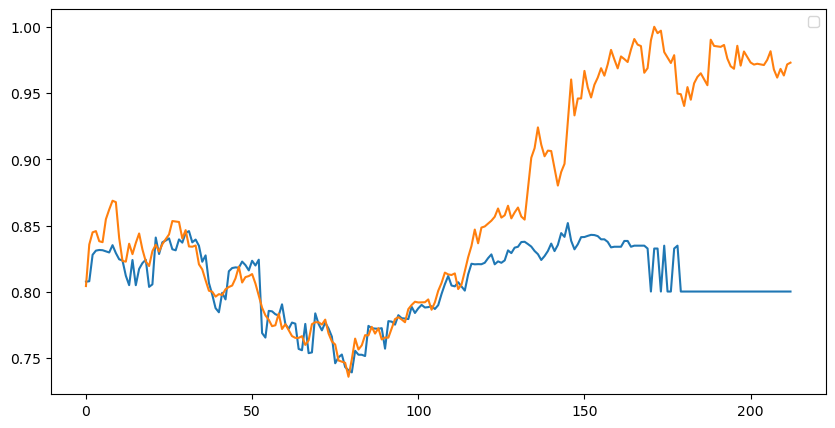

In [39]:
xgb_model=XGBRegressor().fit(x_train,y_train)
predt_xgb=xgb_model.predict(x_test)
mse_xgb=mean_squared_error(y_test,predt_xgb)
mape_xgb=mean_absolute_percentage_error(y_test,predt_xgb)
plt.figure(figsize=(10,5))
plt.plot(predt_xgb)
plt.plot(y_test)
plt.legend()
plt.show()

In [40]:
results=pd.DataFrame({'Model':['Decision Tree','Linear Regression','Random Forest','XGBoost','LSTM']
                     ,'MSE':[mse_dec,mse_linear,mse_random,mse_xgb,mse_lstm],
                     'MAPE':[mape_dec,mape_linear,mape_random,mape_xgb,mape_lstm]})

In [41]:
results.sort_values('MSE')

,Model,MSE,MAPE
1,Linear Regression,0.000096,0.008392
4,LSTM,0.000116,0.009095
0,Decision Tree,0.005972,0.055987
2,Random Forest,0.007936,0.068376
3,XGBoost,0.008126,0.063465


### Model Evaluvation

In [23]:
resid=y_test-predt_linear2

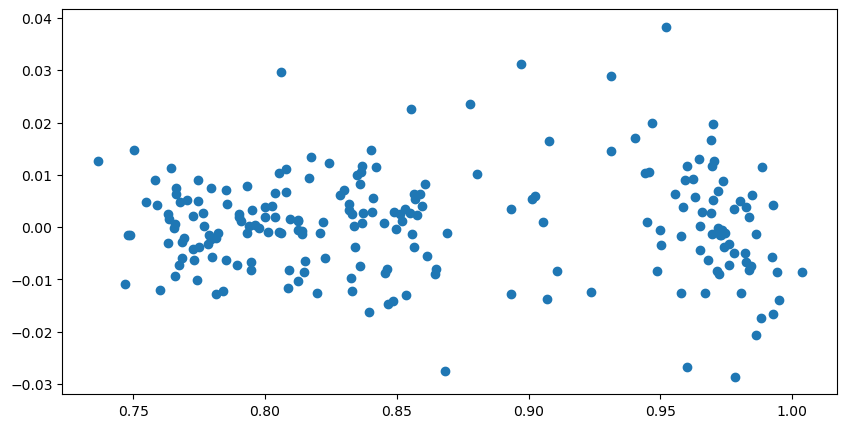

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(predt_linear2,resid)

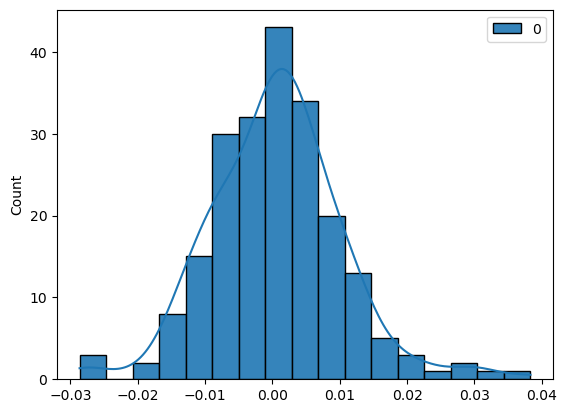

In [25]:
sns.histplot(resid,kde=True,color='blue',alpha=0.9)
plt.show()

## Final Model

In [60]:
x_final,y_final=prepare_data(df2,70)

In [61]:
linear_final=LinearRegression().fit(x_final,y_final)
train_predt_finnal=linear_final.predict(x_final)

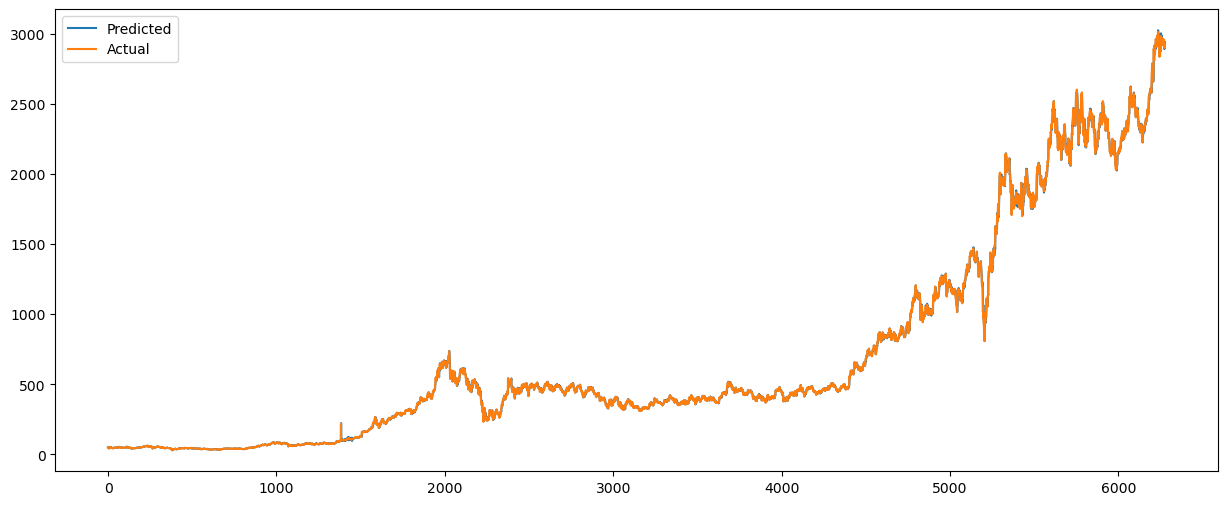

In [62]:
plt.figure(figsize=(15,6))
plt.plot(minmax.inverse_transform(train_predt_finnal),label='Predicted')
plt.plot(minmax.inverse_transform(y_final),label='Actual')
plt.legend()
plt.show()

In [63]:
lastdays=test_data[-70:]

In [64]:
type(lastdays)

numpy.ndarray

In [66]:
future=[]
n_features=70
numberofdays=240
for i in range (numberofdays):
    x_input = lastdays.reshape((1, n_features))
    final_predt=linear_final.predict(x_input)[0]
    future.append(final_predt)
    lastdays = np.append(lastdays[1:], final_predt)

In [67]:
start_date = '2024-05-01'
end_date = '2025-04-01'

business_days = pd.bdate_range(start=start_date, end=end_date)

# Print the business dates
print(business_days)

DatetimeIndex(['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-06',
               '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10',
               '2024-05-13', '2024-05-14',
               ...
               '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24',
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01'],
              dtype='datetime64[ns]', length=240, freq='B')


In [68]:
flattened_data = [val[0] for val in future]

In [93]:
resultdf=pd.DataFrame()

In [94]:
resultdf['Dates']=business_days
resultdf['predicted']=flattened_data

In [95]:
resultdf['predicted']=minmax.inverse_transform(resultdf[['predicted']])

In [96]:
resultdf

,Dates,predicted
0,2024-05-01,2938.607909
1,2024-05-02,2939.187726
2,2024-05-03,2936.520617
3,2024-05-06,2943.672219
4,2024-05-07,2938.558615
...,...,...
235,2025-03-26,3301.054425
236,2025-03-27,3302.614189
237,2025-03-28,3304.298921
238,2025-03-31,3305.960989


In [97]:
resultdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Dates      240 non-null    datetime64[ns]
 1   predicted  240 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [82]:
resultdf.set_index('Dates',inplace=True)

In [83]:
resultdf.to_csv('predicted.csv')

In [90]:
resultdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2024-05-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   predicted  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [102]:
result = resultdf.loc[resultdf['Dates'] == '2025-04-01']['predicted']


In [103]:
result

239    3307.543477
Name: predicted, dtype: float64